<a href="https://colab.research.google.com/github/iamviji/project/blob/master/ToRead/PyLDPC_CommPy_ITPP_BER_LDPC_50_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!git clone https://github.com/veeresht/CommPy.git
import sys
sys.path.append('./CommPy')

fatal: destination path 'CommPy' already exists and is not an empty directory.


In [34]:
import commpy.channels as chan
import commpy.modulation as mod
import commpy.utilities as util
!pip install pyldpc

In [35]:
import pyldpc
import numpy 
import time


In [36]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 8
num_bits_in_parity_check = 9 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [37]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message



In [38]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 9 channel_size= 18
input_message_size= 9 channel_size= 18
[[1 0 0 ... 0 1 1]
 [0 1 1 ... 0 0 0]
 [1 0 1 ... 1 1 0]
 ...
 [1 0 0 ... 1 1 1]
 [0 0 1 ... 1 0 0]
 [0 1 0 ... 1 0 0]]


In [39]:
import commpy
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)    
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc=numpy.append(bler_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 7.11s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 13.99s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 20.79s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 27.74s
SNR: 0.000:
 -> BER: 0.64
 -> Total Time: 69.63s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 5.89s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 11.77s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 18.18s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 24.15s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 59.98s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 5.48s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 11.34s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 17.33s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 22.54s
SNR: 1.000:
 -> BER: 0.52
 -> Total Time: 56.69s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 4.78s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 9.36s
SNR: 1.500 - Iter: 750 - Last

In [40]:
modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_commpy_psk_2  = numpy.array(())
times_per_iter_pyldpc_commpy_psk_2= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc_commpy_psk_2=numpy.append(bler_per_iter_pyldpc_commpy_psk_2 ,ber)
  times_per_iter_pyldpc_commpy_psk_2=numpy.append(times_per_iter_pyldpc_commpy_psk_2, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 6.37s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 12.99s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 19.68s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 25.91s
SNR: 0.000:
 -> BER: 0.54
 -> Total Time: 64.94s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 5.79s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 11.68s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 18.43s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 24.09s
SNR: 0.500:
 -> BER: 0.48
 -> Total Time: 59.99s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 5.46s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 10.95s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 16.28s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 21.71s
SNR: 1.000:
 -> BER: 0.42
 -> Total Time: 54.41s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 4.31s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 9.02s
SNR: 1.500 - Iter: 750 - Last

In [41]:
modem = mod.PSKModem(4) #QPSK
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_commpy_psk_4  = numpy.array(())
times_per_iter_pyldpc_commpy_psk_4= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc_commpy_psk_4=numpy.append(bler_per_iter_pyldpc_commpy_psk_4 ,ber)
  times_per_iter_pyldpc_commpy_psk_4=numpy.append(times_per_iter_pyldpc_commpy_psk_4, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 7.80s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 15.75s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 23.82s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 32.08s
SNR: 0.000:
 -> BER: 0.79
 -> Total Time: 79.46s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 7.24s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 15.18s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 23.05s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 30.15s
SNR: 0.500:
 -> BER: 0.78
 -> Total Time: 75.61s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 7.74s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 15.14s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 22.97s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 30.70s
SNR: 1.000:
 -> BER: 0.75
 -> Total Time: 76.55s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 7.79s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 15.59s
SNR: 1.500 - Iter: 750 - Las

In [42]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,9))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_2  = numpy.array(())
times_per_iter_uncoded_commpy_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_commpy_psk_2=numpy.append(bler_per_iter_uncoded_commpy_psk_2 ,ber)
  times_per_iter_uncoded_commpy_psk_2=numpy.append(times_per_iter_uncoded_commpy_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.000:
 -> BER: 0.51
 -> Total Time: 0.31s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.13s
SNR: 0.500:
 -> BER: 0.47
 -> Total Time: 0.32s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 1.000:
 -> BER: 0.40
 -> Total Time: 0.31s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [43]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,10))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_commpy_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_commpy_psk_4=numpy.append(bler_per_iter_uncoded_commpy_psk_4 ,ber)
  times_per_iter_uncoded_commpy_psk_4=numpy.append(times_per_iter_uncoded_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.000:
 -> BER: 0.82
 -> Total Time: 0.28s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.500:
 -> BER: 0.78
 -> Total Time: 0.30s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 1.000:
 -> BER: 0.73
 -> Total Time: 0.29s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [44]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,100))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_commpy_psk_4  = numpy.array(())
ber_per_iter_uncoded_100_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_100_commpy_psk_4 = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_100_commpy_psk_4=numpy.append(bler_per_iter_uncoded_100_commpy_psk_4 ,ber)
  times_per_iter_uncoded_100_commpy_psk_4=numpy.append(times_per_iter_uncoded_100_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.17s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.25s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.33s
SNR: 0.000:
 -> BER: 1.00
 -> Total Time: 0.84s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.18s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.26s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.34s
SNR: 0.500:
 -> BER: 1.00
 -> Total Time: 0.87s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.09s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.18s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.26s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.34s
SNR: 1.000:
 -> BER: 1.00
 -> Total Time: 0.87s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.16s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [45]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,9))

modem = mod.PSKModem(8)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_8  = numpy.array(())
times_per_iter_uncoded_commpy_psk_8 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_commpy_psk_8=numpy.append(bler_per_iter_uncoded_commpy_psk_8 ,ber)
  times_per_iter_uncoded_commpy_psk_8=numpy.append(times_per_iter_uncoded_commpy_psk_8, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.000:
 -> BER: 0.93
 -> Total Time: 0.30s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.500:
 -> BER: 0.93
 -> Total Time: 0.28s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 1.000:
 -> BER: 0.91
 -> Total Time: 0.28s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

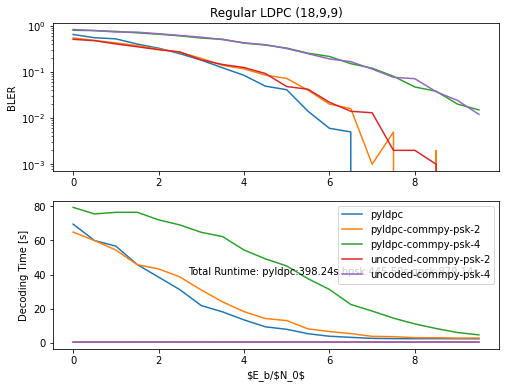

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [47]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/iamviji/py-itpp.git
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .  
!cd py-itpp; ls ; pip3 install -e .  
!cat py-itpp/setup.py
import sys
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp # import itpp is not working, after this hack i started to work
sys.path.append('./py-itpp/lib')
#!pip install gwpy &> /dev/null

Reading package lists... Done
Building dependency tree       
Reading state information... Done
autoconf is already the newest version (2.69-11).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtool is already the newest version (2.4.6-2).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libblas-dev is already the newest version (3.7.1-4ubuntu1).
libfftw3-dev is already the newest version (3.3.7-1).
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.
Cloning into 'itpp'...
remote: Enumerating objects: 14431, done.
remote: Total 14431 (delta 0), reused 0 (delta 0), pack-reused 14431
Receiving objects: 100% (14431/14431), 4.88 MiB | 3.71 MiB/s, done.
Resolving deltas: 100% (12154/12154), done.

In [48]:
import pyitpp as itpp
from matplotlib import pyplot as plt

In [49]:
nrof_bits = 9
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_2  = numpy.array(())
times_per_iter_uncoded_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_2=numpy.append(bler_per_iter_uncoded_itpp_psk_2 ,ber)
  times_per_iter_uncoded_itpp_psk_2=numpy.append(times_per_iter_uncoded_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.49
 -> Total Time: 0.05s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.47
 -> Total Time: 0.05s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.38
 -> Total Time: 0.05s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [50]:
nrof_bits = 9
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_bpsk  = numpy.array(())
times_per_iter_uncoded_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_bpsk=numpy.append(bler_per_iter_uncoded_itpp_bpsk ,ber)
  times_per_iter_uncoded_itpp_bpsk=numpy.append(times_per_iter_uncoded_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.79
 -> Total Time: 0.04s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.74
 -> Total Time: 0.04s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.69
 -> Total Time: 0.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [51]:
nrof_bits = 10
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_4=numpy.append(bler_per_iter_uncoded_itpp_psk_4 ,ber)
  times_per_iter_uncoded_itpp_psk_4=numpy.append(times_per_iter_uncoded_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.79
 -> Total Time: 0.05s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.80
 -> Total Time: 0.04s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.75
 -> Total Time: 0.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [52]:
nrof_bits = 100
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_100_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_100_itpp_psk_4=numpy.append(bler_per_iter_uncoded_100_itpp_psk_4 ,ber)
  times_per_iter_uncoded_100_itpp_psk_4=numpy.append(times_per_iter_uncoded_100_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BER: 1.00
 -> Total Time: 0.10s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BER: 1.00
 -> Total Time: 0.11s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.05s
SNR: 1.000:
 -> BER: 1.00
 -> Total Time: 0.12s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [53]:
nrof_bits = 9
modulator = itpp.comm.PSK(8)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_8  = numpy.array(())
times_per_iter_uncoded_itpp_psk_8 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_8=numpy.append(bler_per_iter_uncoded_itpp_psk_8 ,ber)
  times_per_iter_uncoded_itpp_psk_8=numpy.append(bler_per_iter_uncoded_itpp_psk_8, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.92
 -> Total Time: 0.04s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.90
 -> Total Time: 0.04s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.90
 -> Total Time: 0.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

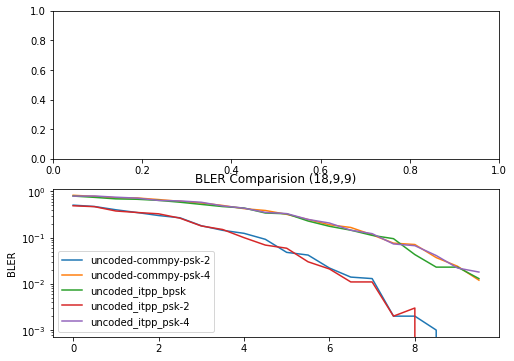

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="uncoded_itpp_bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [55]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_bpsk  = numpy.array(())
times_per_iter_ham_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_bpsk=numpy.append(bler_per_iter_ham_itpp_bpsk ,ber)
  times_per_iter_ham_itpp_bpsk=numpy.append(times_per_iter_ham_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BER: 0.53
 -> Total Time: 0.10s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BER: 0.47
 -> Total Time: 0.09s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BER: 0.41
 -> Total Time: 0.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [56]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_2  = numpy.array(())
times_per_iter_ham_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_psk_2=numpy.append(bler_per_iter_ham_itpp_psk_2 ,ber)
  times_per_iter_ham_itpp_psk_2=numpy.append(times_per_iter_ham_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.000:
 -> BER: 0.17
 -> Total Time: 0.09s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BER: 0.15
 -> Total Time: 0.09s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 1.000:
 -> BER: 0.10
 -> Total Time: 0.09s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [57]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_4  = numpy.array(())
times_per_iter_ham_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    #print ("x")
    #print (source_bits)
    encoded_bits = hamm.encode(source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    #print (demodulated_bits)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_psk_4=numpy.append(bler_per_iter_ham_itpp_psk_4 ,ber)
  times_per_iter_ham_itpp_psk_4=numpy.append(times_per_iter_ham_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BER: 0.53
 -> Total Time: 0.09s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BER: 0.47
 -> Total Time: 0.09s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 1.000:
 -> BER: 0.39
 -> Total Time: 0.09s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [58]:
print ("bler_per_iter_ham_itpp_psk_4=",bler_per_iter_ham_itpp_psk_4)

bler_per_iter_ham_itpp_psk_4= [0.531 0.472 0.394 0.352 0.313 0.23  0.164 0.152 0.122 0.08  0.05  0.048
 0.027 0.018 0.004 0.002 0.    0.    0.    0.   ]


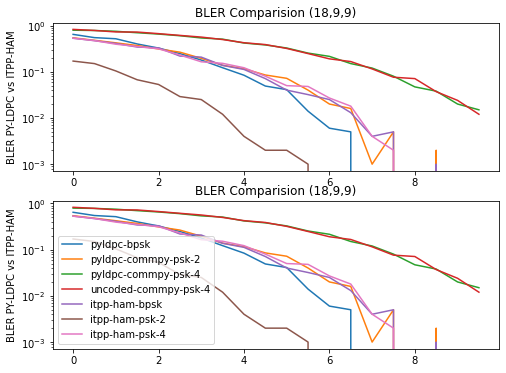

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [60]:
nrof_bits =14
bch = itpp.comm.bch(15, 2, False)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_bch_itpp_psk_4  = numpy.array(())
times_per_iter_bch_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = itpp.base.bvec ()
    #print ("x")
    #print (source_bits)
    bch.encode(source_bits, encoded_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    #print (demodulated_bits)
    decoded_bits = itpp.base.bvec ()
    bch.decode(demodulated_bits, decoded_bits) 
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_bch_itpp_psk_4=numpy.append(bler_per_iter_bch_itpp_psk_4 ,ber)
  times_per_iter_bch_itpp_psk_4=numpy.append(times_per_iter_bch_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 0.000:
 -> BER: 0.65
 -> Total Time: 0.38s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 0.500:
 -> BER: 0.59
 -> Total Time: 0.37s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 1.000:
 -> BER: 0.52
 -> Total Time: 0.36s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [61]:
options =itpp.ivec("36 12")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (100, 5, 10, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_50_100_itpp_psk_4  = numpy.array(())
ber_per_iter_ldpc_50_100_itpp_psk_4  = numpy.array(())
times_per_iter_ldpc_50_100_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,bler,total_time))
  ber_per_iter_ldpc_50_100_itpp_psk_4=numpy.append(ber_per_iter_ldpc_50_100_itpp_psk_4 ,ber)
  bler_per_iter_ldpc_50_100_itpp_psk_4=numpy.append(bler_per_iter_ldpc_50_100_itpp_psk_4 ,bler)
  times_per_iter_ldpc_50_100_itpp_psk_4=numpy.append(times_per_iter_ldpc_50_100_itpp_psk_4, total_time)

nrof_bits= 50 nvar= 100 ncheck= 50
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 3.78s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 7.54s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 11.31s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 15.09s
SNR: 0.000:
 -> BER: 1.00
 -> Total Time: 37.73s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 3.78s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 7.57s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 11.35s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 15.13s
SNR: 0.500:
 -> BER: 1.00
 -> Total Time: 37.83s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 3.77s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 7.57s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 11.37s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 15.16s
SNR: 1.000:
 -> BER: 1.00
 -> Total Time: 37.88s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 3.79s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 7.5

In [77]:
options =itpp.ivec("18 9")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_psk_2  = numpy.array(())
ber_per_iter_ldpc_itpp_psk_2  = numpy.array(())
times_per_iter_ldpc_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,bler,total_time))
  ber_per_iter_ldpc_itpp_psk_2=numpy.append(ber_per_iter_ldpc_itpp_psk_2 ,ber)
  bler_per_iter_ldpc_itpp_psk_2=numpy.append(bler_per_iter_ldpc_itpp_psk_2 ,bler)
  times_per_iter_ldpc_itpp_psk_2=numpy.append(times_per_iter_ldpc_itpp_psk_2, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.11s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.17s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.22s
SNR: 0.000:
 -> BER: 0.11
 -> Total Time: 0.56s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.18s
SNR: 0.500:
 -> BER: 0.07
 -> Total Time: 0.45s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.13s
SNR: 1.000:
 -> BER: 0.03
 -> Total Time: 0.33s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 1.50

In [78]:
print (bler_per_iter_ldpc_50_100_itpp_psk_4)
print (ber_per_iter_ldpc_50_100_itpp_psk_4)
print (ber_per_iter_ldpc_itpp_psk_4)


[0.999 1.    0.998 0.986 0.923 0.713 0.354 0.13  0.044 0.01  0.002 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.1578  0.14146 0.1273  0.1078  0.08884 0.06044 0.03064 0.01238 0.00382
 0.0014  0.00024 0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]
[0.12455556 0.10544444 0.077      0.06655556 0.04444444 0.03044444
 0.02377778 0.01244444 0.00577778 0.00322222 0.00122222 0.00055556
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [64]:
options =itpp.ivec("18 6")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_psk_4  = numpy.array(())
ber_per_iter_ldpc_itpp_psk_4  = numpy.array(())
times_per_iter_ldpc_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,bler,total_time))
  ber_per_iter_ldpc_itpp_psk_4=numpy.append(ber_per_iter_ldpc_itpp_psk_4 ,ber)
  bler_per_iter_ldpc_itpp_psk_4=numpy.append(bler_per_iter_ldpc_itpp_psk_4 ,bler)
  times_per_iter_ldpc_itpp_psk_4=numpy.append(times_per_iter_ldpc_itpp_psk_4, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.23s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.46s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.69s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.91s
SNR: 0.000:
 -> BER: 0.64
 -> Total Time: 2.29s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.20s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.41s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.62s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.83s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 2.05s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.17s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.34s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.51s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.70s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 1.72s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.15s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.30s
SNR: 1.50

In [65]:
print ("bler_per_iter_ldpc_itpp_psk_4=", bler_per_iter_ldpc_itpp_psk_4)

bler_per_iter_ldpc_itpp_psk_4= [0.636 0.535 0.439 0.352 0.254 0.188 0.14  0.081 0.043 0.028 0.016 0.006
 0.005 0.001 0.    0.    0.    0.    0.    0.   ]


In [66]:
options =itpp.ivec("18 6")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_bpsk  = numpy.array(())
ber_per_iter_ldpc_itpp_bpsk  = numpy.array(())
times_per_iter_ldpc_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,bler,total_time))
  ber_per_iter_ldpc_itpp_bpsk=numpy.append(ber_per_iter_ldpc_itpp_bpsk ,ber)
  bler_per_iter_ldpc_itpp_bpsk=numpy.append(bler_per_iter_ldpc_itpp_bpsk ,bler)
  times_per_iter_ldpc_itpp_bpsk=numpy.append(times_per_iter_ldpc_itpp_bpsk, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.21s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.40s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.62s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.81s
SNR: 0.000:
 -> BER: 0.56
 -> Total Time: 2.04s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.18s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.36s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.55s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.74s
SNR: 0.500:
 -> BER: 0.48
 -> Total Time: 1.83s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.15s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.30s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.46s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.62s
SNR: 1.000:
 -> BER: 0.34
 -> Total Time: 1.54s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.13s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.25s
SNR: 1.50

NameError: ignored

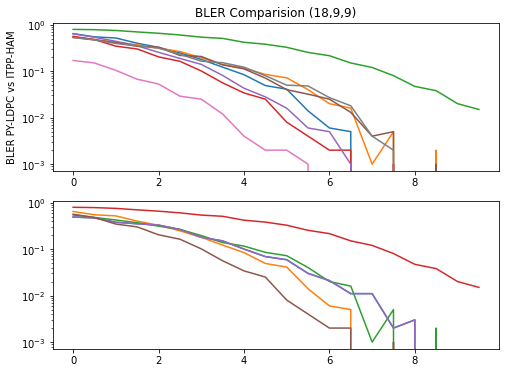

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded-itpp-psk-2") # plot BER vs SNR

ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded-itpp-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_ldpc_180_itpp_psk_4,'', label="uncoded-itpp-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [69]:
print (bler_per_iter_ldpc_itpp_psk_4)
print (bler_per_iter_uncoded_itpp_psk_2)
print (bler_per_iter_uncoded_itpp_psk_4)

[0.636 0.535 0.439 0.352 0.254 0.188 0.14  0.081 0.043 0.028 0.016 0.006
 0.005 0.001 0.    0.    0.    0.    0.    0.   ]
[0.489 0.468 0.377 0.35  0.328 0.264 0.179 0.15  0.1   0.069 0.059 0.03
 0.021 0.011 0.011 0.002 0.003 0.    0.    0.   ]
[0.79  0.797 0.75  0.716 0.639 0.623 0.583 0.486 0.434 0.352 0.331 0.248
 0.207 0.145 0.122 0.073 0.067 0.041 0.022 0.018]


NameError: ignored

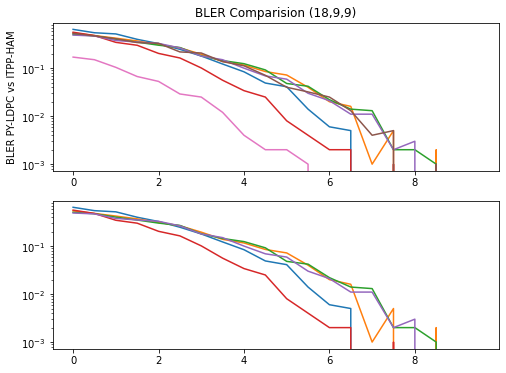

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk_2") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk_2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

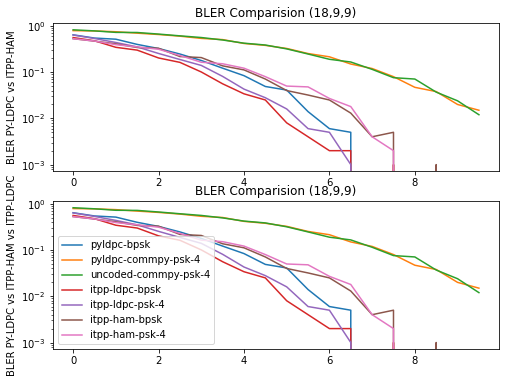

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [73]:
options =itpp.ivec("18 6")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_psk_4  = numpy.array(())
ber_per_iter_ldpc_itpp_psk_4  = numpy.array(())
times_per_iter_ldpc_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,bler,total_time))
  ber_per_iter_ldpc_itpp_psk_4=numpy.append(ber_per_iter_ldpc_itpp_psk_4 ,ber)
  bler_per_iter_ldpc_itpp_psk_4=numpy.append(bler_per_iter_ldpc_itpp_psk_4 ,bler)
  times_per_iter_ldpc_itpp_psk_4=numpy.append(times_per_iter_ldpc_itpp_psk_4, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.20s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.39s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.60s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.78s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 1.98s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.17s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.36s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.56s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.75s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 1.84s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.15s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.30s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.44s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.57s
SNR: 1.000:
 -> BER: 0.39
 -> Total Time: 1.46s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.13s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.26s
SNR: 1.50

In [74]:
import numpy
def bit_error_ratio_uncoded_awgn_bpsk(snr_db):
  
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_bpsk_c(snr_db):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK_c()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_xxx(snr_db, n):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.PSK(n)
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

'''SNR range'''
snrs_db = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)

print('BER Started')
ber_itpp_uncoded_bpsk = [bit_error_ratio_uncoded_awgn_bpsk(snr) for snr in snrs_db]
ber_itpp_uncoded_bpsk_c = [bit_error_ratio_uncoded_awgn_bpsk_c(snr) for snr in snrs_db]
ber_itpp_uncoded_psk_2 = [bit_error_ratio_uncoded_awgn_xxx(snr, 2) for snr in snrs_db]
ber_itpp_uncoded_psk_4 = [bit_error_ratio_uncoded_awgn_xxx(snr, 4) for snr in snrs_db]
ber_itpp_uncoded_psk_8 = [bit_error_ratio_uncoded_awgn_xxx(snr, 8) for snr in snrs_db]
ber_itpp_uncoded_psk_16 = [bit_error_ratio_uncoded_awgn_xxx(snr, 16) for snr in snrs_db]
print('BER Finished')

BER Started
BER Finished


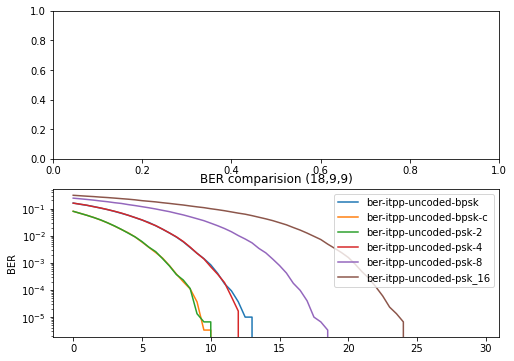

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk,'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk_c,'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_2,'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_4,'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_8,'', label="ber-itpp-uncoded-psk-8") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_16,'', label="ber-itpp-uncoded-psk_16") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

NameError: ignored

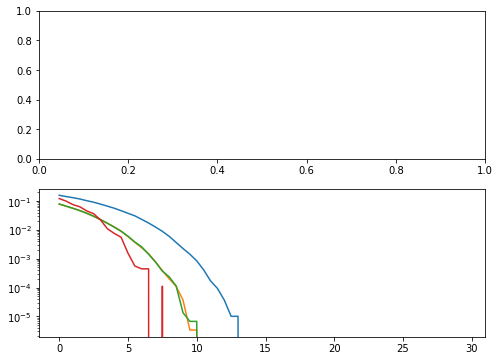

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk,'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk_c,'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_2,'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_bpsk,'', label="ber-itpp-ldpc-bpsk") # plot BER vs SNR
#ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_2,'', label="ber-itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_4,'', label="ber-itpp-ldpc-psk-4") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_itpp_uncoded_bpsk[0:20],'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_bpsk_c[0:20],'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_2[0:20],'', label="ber-itpp-uncoded-psk_2") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_4[0:20],'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_8[0:20],'', label="ber-itpp-uncoded-psk-8") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_16[0:20],'', label="ber-itpp-uncoded-psk-16") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-commpy-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="bler-commpy-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="bler-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.set_ylabel('BER-BLER')
ax1.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax1.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
ax2.semilogy(snrs,ber_itpp_uncoded_bpsk[0:20],'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,ber_itpp_uncoded_psk_2[0:20],'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_qpsk[0:20],'', label="ber_unc_qpsk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_8psk[0:20],'', label="ber_unc_8psk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_16psk[0:20],'', label="ber_unc_16psk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-commpy-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-uncoded-qpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.set_ylabel('BER-BLER')
ax2.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [ ]:
#https://github.com/veeresht/CommPy/blob/master/commpy/examples/conv_encode_decode.py
# Authors: CommPy contributors
# License: BSD 3-Clause

from __future__ import division, print_function  # Python 2 compatibility

import math

import matplotlib.pyplot as plt
import numpy as np

import commpy.channelcoding.convcode as cc
import commpy.channels as chan
import commpy.links as lk
import commpy.modulation as mod
import commpy.utilities as util

# =============================================================================
# Convolutional Code 1: G(D) = [1+D^2, 1+D+D^2]
# Standard code with rate 1/2
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array(2, ndmin=1)

# Generator matrix
g_matrix = np.array((0o5, 0o7), ndmin=2)

# Create trellis data structure
trellis1 = cc.Trellis(memory, g_matrix)

# =============================================================================
# Convolutional Code 1: G(D) = [1+D^2, 1+D^2+D^3]
# Standard code with rate 1/2
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array(3, ndmin=1)

# Generator matrix (1+D^2+D^3 <-> 13 or 0o15)
g_matrix = np.array((0o5, 0o15), ndmin=2)

# Create trellis data structure
trellis2 = cc.Trellis(memory, g_matrix)

# =============================================================================
# Convolutional Code 2: G(D) = [[1, 0, 0], [0, 1, 1+D]]; F(D) = [[D, D], [1+D, 1]]
# RSC with rate 2/3
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array((1, 1))

# Generator matrix & feedback matrix
g_matrix = np.array(((1, 0, 0), (0, 1, 3)))
feedback = np.array(((2, 2), (3, 1)))

# Create trellis data structure
trellis3 = cc.Trellis(memory, g_matrix, feedback, 'rsc')

# =============================================================================
# Basic example using homemade counting and hard decoding
# =============================================================================

# Traceback depth of the decoder
tb_depth = None  # Default value is 5 times the number or memories

for trellis in (trellis1, trellis2, trellis3):
    for i in range(10):
        # Generate random message bits to be encoded
        message_bits = np.random.randint(0, 2, 1000)

        # Encode message bits
        coded_bits = cc.conv_encode(message_bits, trellis)

        # Introduce bit errors (channel)
        coded_bits[np.random.randint(0, 1000)] = 0
        coded_bits[np.random.randint(0, 1000)] = 0
        coded_bits[np.random.randint(0, 1000)] = 1
        coded_bits[np.random.randint(0, 1000)] = 1

        # Decode the received bits
        decoded_bits = cc.viterbi_decode(coded_bits.astype(float), trellis, tb_depth)

        num_bit_errors = util.hamming_dist(message_bits, decoded_bits[:len(message_bits)])

        if num_bit_errors != 0:
            print(num_bit_errors, "Bit Errors found!")
        elif i == 9:
            print("No Bit Errors :)")

# ==================================================================================================
# Complete example using Commpy features and compare hard and soft demodulation. Example with code 1
# ==================================================================================================

# Modem : QPSK
modem = mod.QAMModem(4)

# AWGN channel
channels = chan.SISOFlatChannel(None, (1 + 0j, 0j))

# SNR range to test
SNRs = np.arange(0, 6) + 10 * math.log10(modem.num_bits_symbol)


# Modulation function
def modulate(bits):
    return modem.modulate(cc.conv_encode(bits, trellis1, 'cont'))


# Receiver function (no process required as there are no fading)
def receiver_hard(y, h, constellation, noise_var):
    return modem.demodulate(y, 'hard')


# Receiver function (no process required as there are no fading)
def receiver_soft(y, h, constellation, noise_var):
    return modem.demodulate(y, 'soft', noise_var)


# Decoder function
def decoder_hard(msg):
    return cc.viterbi_decode(msg, trellis1)


# Decoder function
def decoder_soft(msg):
    return cc.viterbi_decode(msg, trellis1, decoding_type='soft')


# Build model from parameters
code_rate = trellis1.k / trellis1.n
model_hard = lk.LinkModel(modulate, channels, receiver_hard,
                          modem.num_bits_symbol, modem.constellation, modem.Es,
                          decoder_hard, code_rate)
model_soft = lk.LinkModel(modulate, channels, receiver_soft,
                          modem.num_bits_symbol, modem.constellation, modem.Es,
                          decoder_soft, code_rate)

# Test
BERs_hard = model_hard.link_performance(SNRs, 10000, 600, 5000, code_rate)
BERs_soft = model_soft.link_performance(SNRs, 10000, 600, 5000, code_rate)
plt.semilogy(SNRs, BERs_hard, 'o-', SNRs, BERs_soft, 'o-')
plt.grid()
plt.xlabel('Signal to Noise Ration (dB)')
plt.ylabel('Bit Error Rate')
plt.legend(('Hard demodulation', 'Soft demodulation'))
plt.show()

In [ ]:
print (bler_per_iter_ldpc_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_2=",  bler_per_iter_uncoded_commpy_psk_2, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_2=",  bler_per_iter_uncoded_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_4=",  bler_per_iter_uncoded_commpy_psk_4, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_4=",  bler_per_iter_uncoded_itpp_psk_4)
print ("bler_per_iter_uncoded_itpp_psk_8=",  bler_per_iter_uncoded_itpp_psk_8)

In [ ]:
print (bler_per_iter_ldpc_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_2=",  bler_per_iter_uncoded_commpy_psk_2, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_2=",  bler_per_iter_uncoded_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_4=",  bler_per_iter_uncoded_commpy_psk_4, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_4=",  bler_per_iter_uncoded_itpp_psk_4)
print ("bler_per_iter_uncoded_itpp_psk_8=",  bler_per_iter_uncoded_itpp_psk_8)
print ("bler_per_iter_uncoded_commpy_psk_8=",  bler_per_iter_uncoded_commpy_psk_8)

In [ ]:
print ("bler_per_iter_ham_itpp_bpsk", bler_per_iter_ham_itpp_bpsk)
print ("bler_per_iter_ham_itpp_psk_4", bler_per_iter_ham_itpp_psk_4)

In [ ]:
print (bler_per_iter_ldpc_50_100_itpp_psk_4)
print (bler_per_iter_uncoded_100_commpy_psk_4)
print (bler_per_iter_uncoded_100_itpp_psk_4)

print (ber_per_iter_ldpc_50_100_itpp_psk_4)


In [ ]:
# File:   hamming.py
# Brief:  Simulates a Hamming coded radio link over AWGN channel
# Author: Vidit Saxena
#
# Usage:  import hamming
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

#import itpp

def block_error_ratio_hamming_awgn(snr_db, block_size):
    
    mapping_k_m = {4: 3} # Mapping from k (block size) to m. m = 3 implies (7,4) code
    m = mapping_k_m[block_size]
     
    '''Hamming encoder and decoder instance'''
    hamm = itpp.comm.Hamming_Code(m)
    n = pow(2,m) - 1 # channel use
    rate = float(block_size)/float(n)
    
    '''Generate random bits'''
    nrof_bits = 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    
    '''Encode the bits'''
    encoded_bits = hamm.encode(source_bits)
    
    '''Modulate the bits'''
    modulator_ = itpp.comm.modulator_2d()
    constellation = itpp.cvec('-1+0i, 1+0i')
    symbols = itpp.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(encoded_bits)
    
    '''Add the effect of channel to the signal'''
    noise_variance = 1.0 / (rate * pow(10, 0.1 * snr_db))
    noise = itpp.randn_c(tx_signal.length())
    noise *= itpp.math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Decode the received bits'''
    decoded_bits = hamm.decode(demodulated_bits) 
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, decoded_bits)
    return blerc.get_errorrate()

In [ ]:
# File:   uncoded.py
# Brief:  Simulates uncoded link over AWGN channel 
# Author: Vidit Saxena
#
# Usage:  import uncoded
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------



def block_error_ratio_uncoded_awgn(snr_db, block_size):
    '''Generate random bits'''
    nrof_bits = 3 * 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    rate = 1.0
    
    '''Modulate the bits'''
    modulator_ = itpp.comm.modulator_2d()
    constellation = itpp.cvec('-1+0i, 1+0i')
    symbols = itpp.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    noise_variance = 1.0 / (rate * pow(10, 0.1 * snr_db))
    noise = itpp.randn_c(tx_signal.length())
    noise *= itpp.math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, demodulated_bits)
    return blerc.get_errorrate()

In [ ]:
# File:   autoencoder.py
# Brief:  Neural network autoencoded radio link over AWGN channel 
# Author: Vidit Saxena
#
# Usage:  import autoencoder
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

import tensorflow as tf
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

def block_error_ratio_autoencoder_awgn(snrs_db, block_size, channel_use, batch_size, nrof_steps):
    
    print('block_size %d'%(block_size))
    print('channel_use %d'%(channel_use))
    
    rate = float(block_size)/float(channel_use)
    print('rate %0.2f'%(rate))
    
    '''The input is one-hot encoded vector for each codeword'''
    alphabet_size = pow(2, block_size)
    alphabet = np.eye(alphabet_size, dtype = 'float32') # One-hot encoded values
    
    '''Repeat the alphabet to create training and test datasets'''
    train_dataset = np.transpose(np.tile(alphabet, int(batch_size)))
    test_dataset = np.transpose(np.tile(alphabet, int(batch_size * 1000)))
    
    print('--Setting up autoencoder graph--')
    input, output, noise_std_dev, h_norm = _implement_autoencoder(alphabet_size, channel_use)
    
    print( '--Setting up training scheme--')
    train_step = _implement_training(output, input)
    
    print('--Setting up accuracy--')
    accuracy = _implement_accuracy(output, input)

    print('--Starting the tensorflow session--')
    sess = _setup_interactive_tf_session()
    _init_and_start_tf_session(sess)
    
    print('--Training the autoencoder over awgn channel--')
    _train(train_step, input, noise_std_dev, nrof_steps, train_dataset, snrs_db, rate, accuracy)
    
    print('--Evaluating autoencoder performance--')
    bler = _evaluate(input, noise_std_dev, test_dataset, snrs_db, rate, accuracy)
    
    print('--Closing the session--')
    _close_tf_session(sess)
    
    return bler
    
def _setup_tf_session():
    return tf.Session()

def _setup_interactive_tf_session():
    return tf.compat.v1.InteractiveSession()

def _init_and_start_tf_session():
    init = tf.compat.v1.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    return sess

def _init_and_start_tf_session(sess):
    sess.run(tf.compat.v1.global_variables_initializer())
    
def _close_tf_session(sess):
    sess.close
    
def _weight_variable(shape):
    initial = tf.random.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def _bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

def _implement_autoencoder(input_dimension, encoder_dimension):
    input = tf.compat.v1.placeholder(tf.float32, [None, input_dimension])
    
    '''Densely connected encoder layer'''
    W_enc1 = _weight_variable([input_dimension, input_dimension])
    b_enc1 = _bias_variable([input_dimension])
    
    h_enc1 = tf.nn.relu(tf.matmul(input, W_enc1) + b_enc1)
    
    '''Densely connected encoder layer'''
    W_enc2 = _weight_variable([input_dimension, encoder_dimension])
    b_enc2 = _bias_variable([encoder_dimension])
    
    h_enc2 = tf.matmul(h_enc1, W_enc2) + b_enc2
    
    '''Normalization layer'''
    normalization_factor = tf.math.reciprocal(tf.sqrt(tf.reduce_sum(tf.square(h_enc2), 1))) * np.sqrt(encoder_dimension)
    h_norm = tf.multiply(tf.tile(tf.expand_dims(normalization_factor, 1), [1, encoder_dimension]), h_enc2)

    '''AWGN noise layer'''
    noise_std_dev = tf.compat.v1.placeholder(tf.float32)
    channel = tf.random.normal(tf.shape(h_norm), stddev=noise_std_dev)
    h_noisy = tf.add(h_norm, channel)
    
    '''Densely connected decoder layer'''
    W_dec1 = _weight_variable([encoder_dimension, input_dimension])
    b_dec1 = _bias_variable([input_dimension])
    
    h_dec1 = tf.nn.relu(tf.matmul(h_noisy, W_dec1) + b_dec1)
        
    '''Output layer'''
    W_out = _weight_variable([input_dimension, input_dimension])
    b_out = _bias_variable([input_dimension])
     
    output = tf.nn.softmax(tf.matmul(h_dec1, W_out) + b_out)
    
    return (input, output, noise_std_dev, h_norm)
    
def _implement_training(output, input):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = output, labels = input))
    
#     train_step = tf.train.GradientDescentOptimizer(1e-2).minimize(cross_entropy) 
    train_step = tf.compat.v1.train.AdamOptimizer(1e-3).minimize(cross_entropy)
    
    return train_step

def _implement_accuracy(output, input):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(input, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

def _train(train_step, input, noise_std_dev, nrof_steps, training_dataset, snrs_db, rate, accuracy):
    print('--Training--')
    print('number of steps %d'%(nrof_steps))
    snr = max(snrs_db)
    snrs_rev = snrs_db[::-1]
    for snr in snrs_rev[0:1]: # Train with higher SNRs first
        print('training snr %0.2f db'%(snr))
        noise = np.sqrt(1.0 / (2 * rate * pow(10, 0.1 * snr)))
        for i in range(int(nrof_steps)):
            batch = training_dataset
            np.random.shuffle(batch)
            if (i + 1) % (nrof_steps/10) == 0: # i = 0 is the first step
                print('training step %d'%(i + 1))
            train_step.run(feed_dict={input: batch, noise_std_dev: noise})
        print('training accuracy %0.4f'%(accuracy.eval(feed_dict={input: batch, noise_std_dev: noise})))

def _evaluate(input, noise_std_dev, test_dataset, snrs_db, rate, accuracy):
    print('--Evaluating NN performance on test dataset--')
    bler = []
    for snr in snrs_db:
        noise = np.sqrt(1.0 / (2 * rate * pow(10, 0.1 * snr)))
        acc = accuracy.eval(feed_dict={input: test_dataset, noise_std_dev: noise})
        bler.append(1.0 - acc)
    return bler

In [ ]:
# File:   radio_autoencoder.py
# Brief:  Simulates a radio link over AWGN channel for Uncoded, Hamming 
#         coded and Neural network autoencoded radio links.
#         Reproduces the results obtained in 
#         "An Introduction to Deep Learning for the Physical Layer",
#         Timothy J. O'Shea, Jakob Hoydis
# Author: Vidit Saxena
#
# Usage:  python radio_autoencoder.py
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

#from src import uncoded, hamming
#from src import autoencoder

from matplotlib import pyplot as plt

''' Function:    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)
    Description: Block error ratio (BLER) vs Signal to Noise Ratio (SNR) 
                 curves for standard channel coding using Hamming codes, 
                 and for 'learnt' optimal representation that are obtained 
                 by training a neural network based autoencoder. Additive 
                 White Gaussian Noise (AWGN) channel is assumed. 
'''  
def _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db):
    
    channel_use = {4: 7} # Mapping to get length of Hamming codeblock from block length 
        
    '''BLER for uncoded BPSK over AWGN channel'''
    print('-------Evaluating BLER for Uncoded (%d,%d) over AWGN-------'%(block_size, block_size))
    bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]
     
    '''BLER for Hamming coded bits over AWGN channel'''
    print('-------Evaluating BLER for Hamming (%d,%d) over AWGN-------' %(channel_use[block_size], block_size))
    bler_hamming = [block_error_ratio_hamming_awgn(snr, block_size) for snr in snrs_db]
    
    '''BLER for Autoencoder coded bits over AWGN channel'''
    print('-------Evaluating BLER for Autoencoder (%d,%d) over AWGN-------' %(channel_use[block_size], block_size))
    batch_size = int(20/block_size)
    nrof_steps = int(200000/block_size)
    bler_autoenc = block_error_ratio_autoencoder_awgn(snrs_db, block_size, channel_use[block_size], batch_size, nrof_steps)
    
    print('-------Plotting results-------')
    plt.figure()
    plt.grid(True)
    plt.semilogy(snrs_db, bler_unc, ls = '-', c = 'b')
    plt.semilogy(snrs_db, bler_hamming, ls = '--', c = 'g')
    plt.semilogy(snrs_db, bler_autoenc, ls = '--', c = 'r', marker = 'o')
    plt.xlabel('SNR [dB]')
    plt.ylabel('Block Error Ratio')
    plt.legend(['Uncoded BPSK (%d,%d)'%(block_size, block_size), 
                'Hamming (%d,%d)'%(channel_use[block_size], block_size),
                'Autoencoder (%d,%d)'%(channel_use[block_size], block_size)],
               loc = 'lower left')
    plt.title('BLER vs SNR for Autoencoder and several baseline communication schemes')
    
    print (bler_unc)
    print(bler_hamming)
    print (bler_autoenc)
    return (bler_hamming, bler_autoenc)

''' Function:    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)
    Description: Block error ratio (BLER) vs Signal to Noise Ratio (SNR) curves 
                 for uncoded transmission, and for 'learnt' optimal 
                 representations of the transmitted bits that are obtained by 
                 training a neural network based autoencoder. Additive White 
                 Gaussian Noise (AWGN) channel is assumed. 
'''  
def _bler_vs_snr_uncoded_autoenc(block_sizes, snrs_db):
    
    plt.figure()
    plt.grid(True)
    legend_strings = []
    colors = iter(list(['b', 'r', 'g', 'b', 'm']))
    for block_size in block_sizes:
        '''BLER for uncoded bits over AWGN channel'''
        print('-------Evaluating BLER for Uncoded BPSK (%d,%d) over AWGN-------' %(block_size, block_size))
        bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]
    
        '''BLER for Autoencoder coded  bits over AWGN channel'''
        print('-------Evaluating BLER for Autoencoder (%d,%d) over AWGN-------' %(block_size, block_size))
        batch_size = 10/block_size
        nrof_steps = 100000/block_size
        bler_autoenc = block_error_ratio_autoencoder_awgn(snrs_db, block_size, block_size, batch_size, nrof_steps)
        
        print('-------Plotting results-------')
        color = next(colors) 
        plt.semilogy(snrs_db, bler_unc, ls = '-', c = color)
        plt.semilogy(snrs_db, bler_autoenc, ls = '--', c = color, marker = 'o')
        
        legend_strings.append('Uncoded BPSK (%d,%d)'%(block_size, block_size))
        legend_strings.append('Autoencoder (%d,%d)'%(block_size, block_size))

    plt.xlabel('SNR [dB]')
    plt.ylabel('Block Error Ratio')
    plt.legend(legend_strings, loc = 'lower left')
    plt.title('BLER vs SNR for Autoencoder and BPSK')
    
if __name__ == '__main__':
    snrs_db = range(-4, 9)
    
    '''BLER for block size 4 with Autoencoder and Hamming'''
    block_size = 4
    channel_use = 7
    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)

    '''BLER for block sizes 2 and 8 with uncoded and Autoencoder'''
    block_sizes = [2, 8]
    _bler_vs_snr_uncoded_autoenc(block_sizes, snrs_db)
    
    plt.show()